## FACET2e BMAD simple example

You will need to install pytao, BMAD, and openpmd-beamphysics (as well as standard libraries like numpy, matplotlib and pandas)

 conda install -c conda-forge bmad
 conda install -c conda-forge pytao, openpmd-beamphysics

In [1]:
from pytao import Tao
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
import math
from os import path,environ
import os
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles
import subprocess

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /nfs/slac/g/beamphysics/cemma/FACET_Bmad_examples/facet_bmad
%env FACET2_LATTICE /sdf/home/s/sanjeev/github/facet2-lattice
print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 
# Note that you can't put a comment at the end of the magic line, jupyter doesn't read it as a comment

env: FACET2_LATTICE=/sdf/home/s/sanjeev/github/facet2-lattice
Make sure enviornment was set!:   /sdf/home/s/sanjeev/github/facet2-lattice


In [2]:
os.getcwd()

'/sdf/home/s/sanjeev/github/bmad'

In [3]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches

In [4]:
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

# Start tao

In [5]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) # Initialize tao object
#tao=Tao('-init {:s}/bmad/models/f2_elec/taoCEedit.init -noplot'.format(environ['FACET2_LATTICE'])) 

In [6]:
print('{:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE']))

/sdf/home/s/sanjeev/github/facet2-lattice/bmad/models/f2_elec/tao.init


In [7]:
import os
print(os.getcwd())

/sdf/home/s/sanjeev/github/bmad


## Plot single particle twiss

In [8]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
tao.ele_gen_attribs(elements[0]);

In [9]:
?tao.lat_list;

Object `tao.lat_list;` not found.


In [10]:
floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep=r"[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
26,26,DL01H,Drift,1.03220,0.09012,9.60305,0.0,1003.11948,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
101,101,QE10511#1,Quadrupole,11.14513,0.05400,3.80475,0.0,1011.40031,-0.61087,0.0,0.0
126,126,BPM10581,Monitor,14.40167,0.00000,1.93688,0.0,1014.06791,-0.61087,0.0,0.0
151,151,QB10731#1,Quadrupole,17.73408,0.05340,0.26540,0.0,1016.91774,-0.30543,0.0,0.0


In [11]:
(floorplan[floorplan.s<9.0].head(60))# The injector up to L0BEND

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
2,2,LOADLOCKF,Drift,0.00000,0.86905,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
3,3,BEGINJ,Marker,0.00000,0.00000,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
4,4,SOL10111,Solenoid,0.00000,0.00000,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
5,5,CATHODEF,Instrument,0.00000,0.00000,10.19510,0.0,1002.27394,-0.61087,0.0,0.0
6,6,DL01A,Drift,0.09729,0.09729,10.13930,0.0,1002.35364,-0.61087,0.0,0.0
7,7,SOL10121#1,Solenoid,0.19729,0.10000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0
8,8,YC10122,VKicker,0.19729,0.00000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0
9,9,XC10121,HKicker,0.19729,0.00000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0
10,10,SQ10122,Multipole,0.19729,0.00000,10.08194,0.0,1002.43556,-0.61087,0.0,0.0


In [12]:
floorplan[floorplan.ElementName.str.contains('BC')][::1].head(670)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
79,79,BCX10451,SBend,8.75911,0.12476,5.17801,0.0,1009.45339,-0.47922,0.0,0.0
81,81,BCX10461,SBend,9.02569,0.12476,5.04798,0.0,1009.68585,-0.61087,0.0,0.0
91,91,BCX10475,SBend,9.98144,0.12476,4.49327,0.0,1010.46376,-0.74251,0.0,0.0
93,93,BCX10481,SBend,10.24803,0.12476,4.31931,0.0,1010.66545,-0.61087,0.0,0.0
225,225,BEGBC11_1,Marker,39.64325,0.00000,-0.00000,0.0,1038.78766,0.00000,0.0,0.0
231,231,BC11CBEG,Marker,40.41234,0.00000,-0.00000,0.0,1039.55675,0.00000,0.0,0.0
232,232,BCX11314,SBend,40.61584,0.20350,0.00957,0.0,1039.75995,0.09410,0.0,0.0
240,240,BCX11331,SBend,43.26506,0.20350,0.24895,0.0,1042.39805,0.00000,0.0,0.0
248,248,BCX11338,SBend,44.29876,0.20350,0.23938,0.0,1043.43145,-0.09410,0.0,0.0
258,258,BCX11355,SBend,46.94798,0.20350,-0.00000,0.0,1046.06955,0.00000,0.0,0.0


In [13]:
# Display all the rf cavity elements
floorplan[floorplan.ElementType.str.contains('cavity')][::1].head(10);

In [14]:
tao.ele_gen_attribs('K11_2A#2')['PHI0']*360 # Phase of a cavity in L1 in degrees

-20.499999999999986

In [15]:
# Display some Rmatrices
# rmatbc11 =np.array(tao.cmd("show matrix BC11CBEG BC11CEND"))
# print(rmatbc11)
# rmatbc14 =np.array(tao.cmd("show matrix BEGBC14E ENDBC14E"))
# print(rmatbc14)
# rmatbc20 =np.array(tao.cmd("show matrix BEGBC20 ENDBC20"))
# print(rmatbc20)

blabla =np.array(tao.cmd("show matrix QE10525 PR10571"))
blabla

array(['Symplectic Error:  0.00E+00', '',
       '     1.00000000     2.64758627     0.00000000     0.00000000     0.00000000     0.00000000   :  1.54074396E-33',
       '     0.00000000     1.00000000     0.00000000     0.00000000     0.00000000     0.00000000   :  0.00000000E+00',
       '     0.00000000     0.00000000     1.00000000     2.64758627     0.00000000     0.00000000   :  0.00000000E+00',
       '     0.00000000     0.00000000     0.00000000     1.00000000     0.00000000     0.00000000   :  0.00000000E+00',
       '     0.00000000     0.00000000     0.00000000     0.00000000     1.00000000     0.00004425   :  0.00000000E+00',
       '     0.00000000     0.00000000     0.00000000     0.00000000     0.00000000     1.00000000   :  0.00000000E+00'],
      dtype='<U110')

In [16]:
tao.cmd('show ele L0BF')

['Element # 1598',
 'Element Name: L0BF',
 'Element Type:  "DUALFEED"',
 'Element Alias:  "ACCL:IN10:400"',
 'Key: Lcavity',
 'S_start, S:      4.860653,      7.955897',
 'Ref_time_start, Ref_time:  1.622954E-08,  2.655434E-08',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  3.0952440E+00 m        31  L_ACTIVE                    =  3.0952440E+00 m',
 '    7  GRADIENT_ERR                =  0.0000000E+00 eV/m',
 '    8  VOLTAGE                     =  6.1058114E+07 Volt      6  GRADIENT                    =  1.9726430E+07 eV/m',
 '    9  VOLTAGE_ERR                 =  0.0000000E+00 Volt',
 '   10  FRINGE_TYPE                 =  Full (4)               11  FRINGE_AT                   =  Both_Ends (3)',
 '   13  SPIN_FRINGE_ON              =  T (1)',
 '   15  RF_FREQUENCY                =  2.8560000E+09 Hz       16  RF_WAVELENGTH               =  1.0496935E-01 m',
 '   17  STATIC_LINEAR_MAP           =  F (0)',
 '   18  LONGITUDINAL_MODE      

In [17]:
tao.ele_methods('K11_2A')

{'mat6_calc_method': 'Auto',
 'tracking_method': 'Bmad_Standard',
 'spin_tracking_method': 'Tracking',
 'csr_method': 'Off',
 'space_charge_method': 'Off',
 'ptc_integration_type': 'Matrix_Kick',
 'field_calc': 'Bmad_Standard',
 'longitudinal_orientation': 1}

In [18]:
#These more general match strings might cause problems by including both lords and slaves!
L1MatchStrings = ["K11_1*", "K11_2*"]
L2MatchStrings = ["K11_4*", "K11_5*", "K11_6*", "K11_7*", "K11_8*", "K12_*", "K13_*", "K14_*"]
L3MatchStrings = ["K15_*", "K16_*", "K17_*", "K18_*", "K19_*"]

#Therefore, use lat_list and these general search strings to get specific elements
#Recall that, by default, lat_list has the flag "-track_only" so lords are not included
#But some of the tracking elements are super_slaves which cannot be `set`

#"-array_out" flag is on by default but if flags are edited, need to re-add manually to get numeric values back

L1MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L1MatchStrings ] )
L2MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L2MatchStrings ] )
L3MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L3MatchStrings ] )


selectMarkers  = np.array(["ENDDL10", "BEGBC11_1", "BC11CEND", "BEGBC14_1", "ENDBC14_2", "BEGBC20", "ENDBC20", "PENT"])

def getEnergyChangeFromElements(activeMatchStrings):
    #VOLTAGE is just gradient times length; need to manually include phase info
    voltagesArr = [tao.lat_list(i, "ele.VOLTAGE", flags="-no_slaves -array_out") for i in activeMatchStrings]
    voltagesArr = np.concatenate(voltagesArr)
    
    angleMultArr = [tao.lat_list(i, "ele.PHI0", flags="-no_slaves -array_out") for i in activeMatchStrings]
    angleMultArr = np.concatenate(angleMultArr)
    angleMultArr = [np.cos(i * (2*3.1415) ) for i in angleMultArr] #Recall Bmad uses units of 1/2pi

    return( np.dot(voltagesArr, angleMultArr) )


def setLinacGradientAuto(activeMatchStrings, targetVoltage): 
    #Set to a fixed gradient so everything is the same. Not exactly physical but probably close
    baseGradient = 1.0e7
    for i in activeMatchStrings: tao.cmd(f'set ele {i} GRADIENT = {baseGradient}')
    
    #See the resulting voltage gain
    voltageSum  = getEnergyChangeFromElements(activeMatchStrings)
    
    #print(voltageSum/1e6)
    
    #Uniformly scale gradient to hit target voltage
    for i in activeMatchStrings: tao.cmd(f'set ele {i} GRADIENT = {baseGradient*targetVoltage/voltageSum}')
    
    voltageSum  = getEnergyChangeFromElements(activeMatchStrings)
    
    #print(voltageSum/1e6)

def setLinacPhase(activeMatchStrings, phi0Deg):
    for i in activeMatchStrings: tao.cmd(f'set ele {i} PHI0 = {phi0Deg / 360.}')

#Broken! If you comma separate too many values it just starts ignoring them...
#def printETOTValues(activeElements):
#    printThing = tao.cmd(f"show lat {','.join(activeElements)} -att E_TOT");
#    [print(row) for row in printThing];

#Broken! If you comma separate too many values it just starts ignoring them...
#def printArbValues(activeElements, attString):
#    printThing = tao.cmd(f"show lat {','.join(activeElements)} -att {attString}");
#    [print(row) for row in printThing];

def printArbValues(activeElements, attString):
    #The .tolist() is because of issues when activeElements is a numpy array
    namesList = [ tao.lat_list(i, "ele.name", flags="-no_slaves -array_out") for i in activeElements.tolist() ]
    namesList = np.concatenate(namesList)
    valuesList = [ tao.lat_list(i, f"ele.{attString}",flags="-no_slaves -array_out") for i in activeElements.tolist() ]
    valuesList = np.concatenate(valuesList) / 1e9
    
    printThing = np.transpose([namesList, valuesList])
    display(pd.DataFrame(printThing))

"""
#print("\n Starting point \n")
printETOTValues(selectMarkers)
#printArbValues( L1MatchStrings, "GRADIENT" )
#print(getEnergyChangeFromElements(L1MatchStrings))

#print("\n Changed phase \n")
setLinacPhase(        L1MatchStrings, -19 )
#printArbValues( L1MatchStrings, "GRADIENT" )
#print(getEnergyChangeFromElements(L1MatchStrings))

#print("\n Changed gradient \n")
setLinacGradientAuto( L1MatchStrings, 0.335e9 - 0.125e9 )
#printArbValues( L1MatchStrings, "GRADIENT" )
#print(getEnergyChangeFromElements(L1MatchStrings))



print("\n Next step \n")
printETOTValues(selectMarkers)
setLinacPhase(        L2MatchStrings, -37 ) 
printArbValues( L1MatchStrings, "GRADIENT" )
setLinacGradientAuto( L2MatchStrings, 4.5e9 - 0.335e9 )

printETOTValues(selectMarkers)
setLinacPhase(        L3MatchStrings, 0 )
setLinacGradientAuto( L3MatchStrings, 10.0e9 - 4.5e9 )
"""

printArbValues(selectMarkers, "E_TOT")

,0,1
0,ENDDL10,0.12499999999999994
1,BEGBC11_1,0.3350000000000763
2,BC11CEND,0.3350000000000763
3,BEGBC14_1,4.500000000001358
4,ENDBC14_2,4.500000000001358
5,BEGBC20,10.000000000002817
6,ENDBC20,10.000000000002817
7,PENT,10.000000000002817


In [19]:
# Phase L1
setLinacPhase(L1MatchStrings, -14)
setLinacGradientAuto( L1MatchStrings, 0.335e9 - 0.125e9 )

# Phase L2
# setLinacPhase(L1MatchStrings, -38)
# setLinacGradientAuto( L2MatchStrings, 4.5e9- 0.335e9 )

In [20]:
# Find the indices corresponding to the L2 RF cavities excluding the feedback stations 14-4 and 14-5
a = floorplan.loc[floorplan.ElementName.str.contains('BC11CEND'), 'Index'].iloc[0]
b = floorplan.loc[floorplan.ElementName.str.contains('BEGBC14_1'), 'Index'].iloc[0]

#condition = (floorplan['Index'] > a) & (floorplan['Index'] < b) & floorplan['ElementType'].str.contains('cavity') &  ~floorplan['ElementName'].str.contains(r'K14_4.*') &  ~floorplan['ElementName'].str.contains(r'K14_5.*') &  ~floorplan['ElementName'].str.contains(r'K.+#.') 
condition = (floorplan['Index'] > a) & (floorplan['Index'] < b) & floorplan['ElementType'].str.contains('cavity') &   ~floorplan['ElementName'].str.contains(r'K.+#.') 

# Select lattice elements that satisfy the above condition
selected_element_names = floorplan.loc[condition, 'ElementName'].tolist()

# Display the selected element names
print(selected_element_names);

['K11_4B', 'K11_4C', 'K11_4D', 'K11_5B', 'K11_5C', 'K11_5D', 'K11_6B', 'K11_6C', 'K11_6D', 'K11_7A', 'K11_7B', 'K11_7C', 'K11_7D', 'K11_8B', 'K11_8C', 'K11_8D', 'K12_1A', 'K12_1B', 'K12_1C', 'K12_1D', 'K12_2B', 'K12_2C', 'K12_2D', 'K12_3B', 'K12_3C', 'K12_3D', 'K12_4B', 'K12_4C', 'K12_4D', 'K12_5B', 'K12_5C', 'K12_5D', 'K12_6B', 'K12_6C', 'K12_6D', 'K12_7B', 'K12_7C', 'K12_7D', 'K12_8B', 'K12_8C', 'K13_1A', 'K13_1B', 'K13_1C', 'K13_1D', 'K13_2B', 'K13_2C', 'K13_2D', 'K13_3B', 'K13_3C', 'K13_3D', 'K13_4B', 'K13_4C', 'K13_4D', 'K13_5B', 'K13_5C', 'K13_5D', 'K13_6B', 'K13_6C', 'K13_6D', 'K13_7B', 'K13_7C', 'K13_7D', 'K13_8B', 'K13_8C', 'K14_1A', 'K14_1B', 'K14_1C', 'K14_1D', 'K14_2B', 'K14_2C', 'K14_2D', 'K14_3B', 'K14_3C', 'K14_3D', 'K14_4B', 'K14_4C', 'K14_4D', 'K14_5B', 'K14_5C', 'K14_5D', 'K14_6B', 'K14_6C']


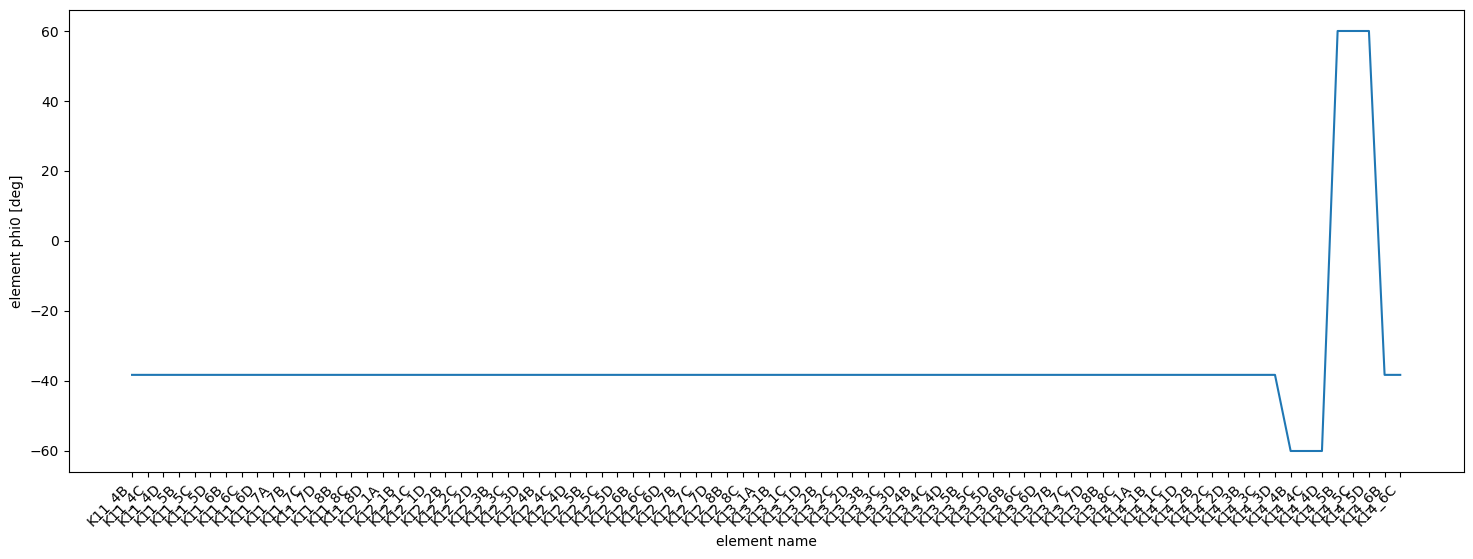

In [21]:
# Plot the RF phase of the cavities in L2 (excluding the feedback stations 14-4 and 14-5)
phi0vals = [];voltagevals = [];
for element_name in selected_element_names:
    element_phase = tao.ele_gen_attribs(element_name)['PHI0'];# Display the phase of the cavity
    element_voltage = tao.ele_gen_attribs(element_name)['VOLTAGE'];# Display the voltage of the cavity
    phi0vals.append(element_phase*360)
    voltagevals.append(element_voltage)
    
plt.figure(figsize=(18,6))
plt.plot(selected_element_names,phi0vals)
plt.xlabel('element name')
plt.ylabel('element phi0 [deg]')
plt.xticks(rotation=45,ha='right');

In [22]:
# Loop through each element name in selected_element_names and change the RF phase
phaseoffset = 2;# Degrees
originalphase = phi0vals[1];#Degrees
if phaseoffset==0:
    voltageoffset = 1;# Voltage offset is multiplicative
else:
    voltageoffset = np.cos(np.deg2rad(originalphase))/np.cos(np.deg2rad(originalphase+phaseoffset));#Adjusts voltage to get the same energy out of L2

for element_name in selected_element_names:
    element_phase = tao.ele_gen_attribs(element_name)['PHI0'];# Phase of the cavity in rad/2*pi
    element_voltage = tao.ele_gen_attribs(element_name)['VOLTAGE'];# Voltage of the cavity
    
    new_element_phase = element_phase+phaseoffset/360;# rad/2pi
    new_element_voltage = element_voltage*voltageoffset;
    
    # Change the phase of each cavity to the new phase
    tao.cmd('set ele {} PHI0={}'.format(element_name, new_element_phase))
    # Change the voltage of each cavity to get the same energy out of it
    tao.cmd('set ele {} VOLTAGE={}'.format(element_name, new_element_voltage))

In [23]:
# Show all the LCAVITY elements and their phases
tao.cmd('show lat LCAVITY::* -att PHI0');

In [24]:
print(selected_element_names[0])
tao.ele_gen_attribs(selected_element_names[0])['PHI0']*360

K11_4B


-36.249999999999844

In [25]:
# Deal with klystrons that have the label format like for example K11_4A#1
a = floorplan.loc[floorplan.ElementName.str.contains('BC11CEND'), 'Index'].iloc[0]
b = floorplan.loc[floorplan.ElementName.str.contains('BEGBC14_1'), 'Index'].iloc[0]
pattern = re.compile(r'(?:K\d+_\d+[A-D]#[1-4])')

# Apply the condition to filter your DataFrame
# condition = (
#     floorplan['ElementName'].str.contains(pattern.pattern, na=False) & 
#     (floorplan['Index'] > a) & 
#     (floorplan['Index'] < b) &
#     ~floorplan['ElementName'].str.contains(r'K14_4.*') &
#     ~floorplan['ElementName'].str.contains(r'K14_5.*')
# )

condition = (
    floorplan['ElementName'].str.contains(pattern.pattern, na=False) & 
    (floorplan['Index'] > a) & 
    (floorplan['Index'] < b) 
)

filtered_floorplan = floorplan.loc[condition, 'ElementName']

# Extract the first 6 characters from each string and convert to list
numbered_klystrons = filtered_floorplan.str[:6].tolist()

from collections import OrderedDict

# Remove duplicates while preserving order
unique_numbered_klystrons = list(OrderedDict.fromkeys(numbered_klystrons))

# Print the unique entries corresponding to the names of the klystrons with '#' in their labels
unique_numbered_klystrons

# Plot the RF phase of those cavities
# phi0vals = [];voltagevals = [];
# for element_name in unique_numbered_klystrons:
#     element_phase = tao.ele_gen_attribs(element_name)['PHI0'];# Display the phase of the cavity
#     element_voltage = tao.ele_gen_attribs(element_name)['VOLTAGE'];# Display the voltage of the cavity
#     phi0vals.append(element_phase*360)
#     voltagevals.append(element_voltage)
    
# plt.figure(figsize=(18,6))
# plt.plot(unique_numbered_klystrons,phi0vals)
# plt.xlabel('element name')
# plt.ylabel('element phi0 [deg]')
# plt.xticks(rotation=45,ha='right');

['K11_4A',
 'K11_5A',
 'K11_6A',
 'K11_8A',
 'K12_2A',
 'K12_3A',
 'K12_4A',
 'K12_5A',
 'K12_6A',
 'K12_7A',
 'K12_8A',
 'K12_8D',
 'K13_2A',
 'K13_3A',
 'K13_4A',
 'K13_5A',
 'K13_6A',
 'K13_7A',
 'K13_8A',
 'K13_8D',
 'K14_2A',
 'K14_3A',
 'K14_4A',
 'K14_5A',
 'K14_6A',
 'K14_6D']

In [26]:
# Loop through klystrons that have the label format like for example K11_4A#1 and change the RF phase
phaseoffset = 2;# Degrees
originalphase = phi0vals[1];#Degrees
if phaseoffset==0:
    voltageoffset = 1;# Voltage offset is multiplicative
else:
    voltageoffset = np.cos(np.deg2rad(originalphase))/np.cos(np.deg2rad(originalphase+phaseoffset));#Adjusts voltage to get the same energy out of L2

for element_name in unique_numbered_klystrons:
    element_phase = tao.ele_gen_attribs(element_name)['PHI0'];# Phase of the cavity in rad/2*pi
    element_voltage = tao.ele_gen_attribs(element_name)['VOLTAGE'];# Voltage of the cavity
    
    new_element_phase = element_phase+phaseoffset/360;# rad/2pi
    new_element_voltage = element_voltage*voltageoffset;
    
    # Change the phase of each cavity to the new phase
    tao.cmd('set ele {} PHI0={}'.format(element_name, new_element_phase))
    # Change the voltage of each cavity to get the same energy out of it
    tao.cmd('set ele {} VOLTAGE={}'.format(element_name, new_element_voltage))

In [27]:
print(tao.ele_gen_attribs('K13_3A')['PHI0']*360)
#tao.cmd('set ele {} PHI0={}'.format('K13_3A', new_element_phase))
#print(tao.ele_gen_attribs('K13_3A#2')['PHI0']*360)

-36.249999999999844


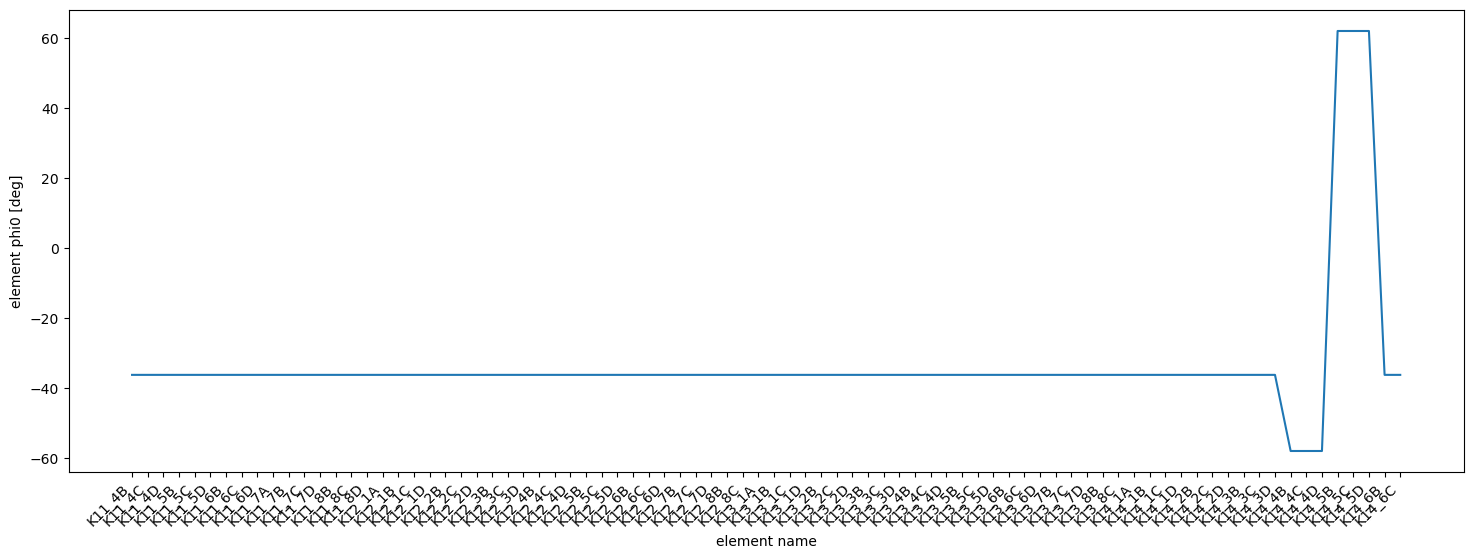

In [28]:
# Plot the RF phase of the cavities in L2 (excluding the feedback stations 14-4 and 14-5) AFTER changing the phase
phi0vals = [];voltagevals = [];
for element_name in selected_element_names:
    element_phase = tao.ele_gen_attribs(element_name)['PHI0'];# Display the phase of the cavity
    element_voltage = tao.ele_gen_attribs(element_name)['VOLTAGE'];# Display the voltage of the cavity
    phi0vals.append(element_phase*360)
    voltagevals.append(element_voltage)
    
plt.figure(figsize=(18,6))
plt.plot(selected_element_names,phi0vals)
plt.xlabel('element name')
plt.ylabel('element phi0 [deg]')
plt.xticks(rotation=45,ha='right');

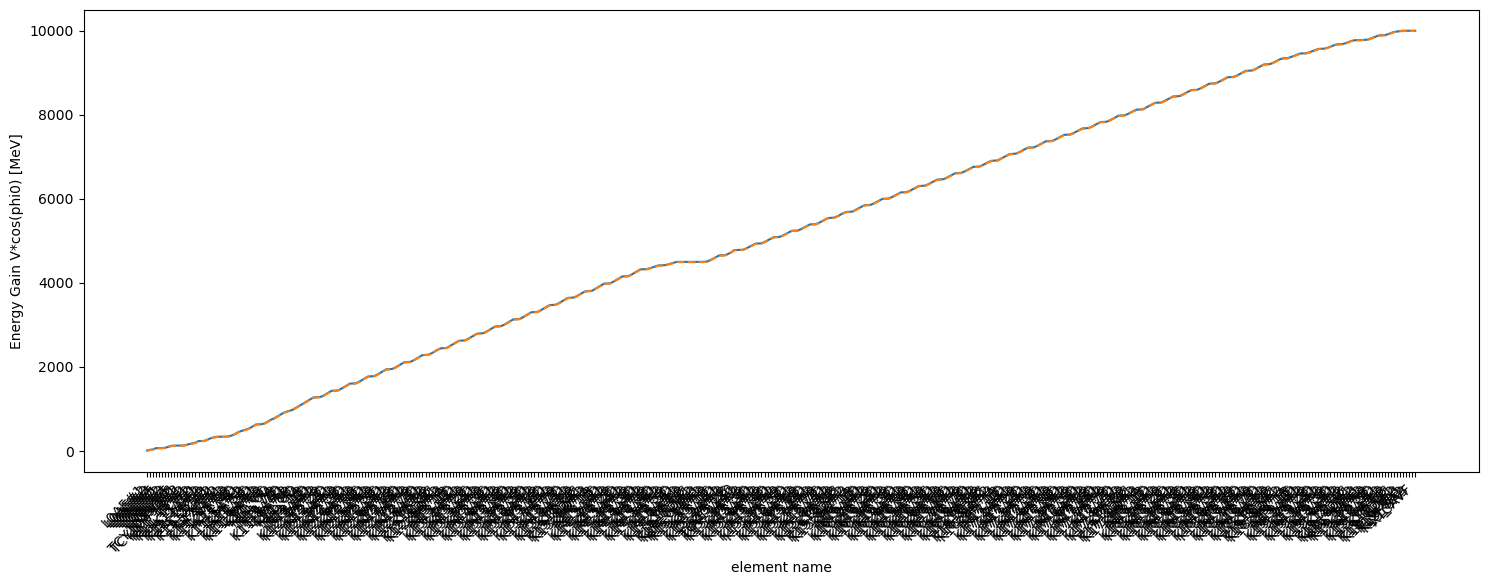

In [29]:
# Plot the energy gain of the beam along the linac
condition = floorplan['ElementType'].str.contains('cavity') 
# Select lattice elements that satisfy the above condition
selected_element_names = floorplan.loc[condition, 'ElementName'].tolist()

egainvals = [];etotvals = [];
for element_name in selected_element_names:
    element_egain = tao.ele_gen_attribs(element_name)['VOLTAGE']*np.cos(tao.ele_gen_attribs(element_name)['PHI0']*2*math.pi)*10**-6;# energy gain in MeV
    element_etot = tao.ele_gen_attribs(element_name)['E_TOT']*10**-6;
    egainvals.append(element_egain)
    etotvals.append(element_etot)
    
plt.figure(figsize=(18,6))
plt.plot(selected_element_names,etotvals);
plt.plot(selected_element_names,np.cumsum(egainvals),linestyle='--')
plt.xlabel('element name')
plt.ylabel('Energy Gain V*cos(phi0) [MeV]')
plt.xticks(rotation=45,ha='right');

In [30]:
tao.ele_head('L0AFEND')['s']

4.1274477

In [31]:
# Energy feedback calcs
voltageoffset = np.cos(np.deg2rad(originalphase))/np.cos(np.deg2rad(originalphase+phaseoffset))
print(originalphase)
print(phaseoffset)
print(voltageoffset)

-38.25
2
0.9738014573165524


In [32]:
#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
alpha_x=np.array([tao.lat_list(x,'ele.a.alpha')[0] for x in floorplan.Index])
alpha_y=np.array([tao.lat_list(x,'ele.b.alpha')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

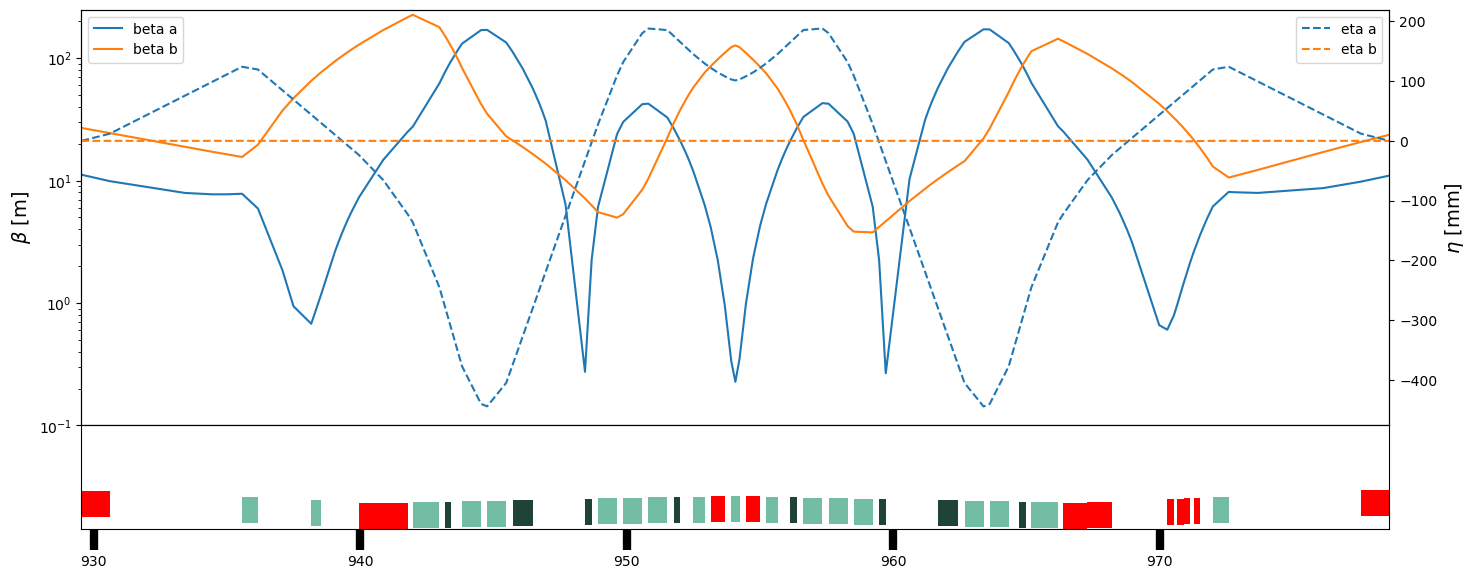

In [33]:
#Plot twiss functions 
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta a')
ax.semilogy(s,beta_y,label='beta b')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta a')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta b')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=tao.ele_head('BEGBC20')['s']
zmax=tao.ele_head('ENDBC20')['s']

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

In [34]:
# Print the twiss parameters at the start of BC20
print(tao.lat_list('BEGBC20','ele.a.alpha'))
print(tao.lat_list('BEGBC20','ele.a.beta'))
print(tao.lat_list('BEGBC20','ele.b.alpha'))
print(tao.lat_list('BEGBC20','ele.b.beta'))

[0.66952451]
[11.17629569]
[1.20730577]
[26.94587978]


1290
11.176295693491822
26.94587978418986
0.6695245096740331
1.2073057706873205


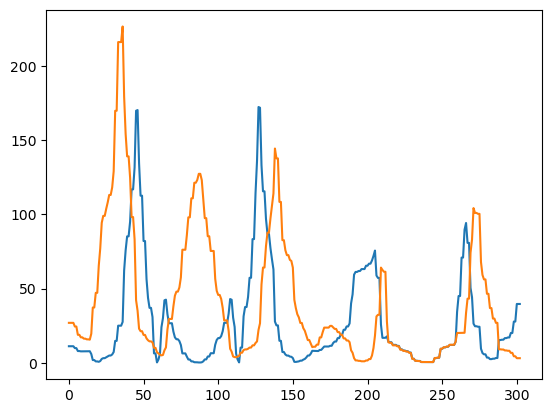

In [35]:
target = tao.ele_head('BEGBC20')['s']
index_closest = np.argmin(np.abs(s - target)) 
print(index_closest)
# Print the twiss parameters at the start of BC20
print(beta_x[index_closest])
print(beta_y[index_closest])
print(alpha_x[index_closest])
print(alpha_y[index_closest])
plt.plot(beta_x[index_closest:])
plt.plot(beta_y[index_closest:])
plt.show()

## Track particles (no csr)

In [36]:
tao.cmd('set beam_init n_particle = 10000'); # limit to 10k particles for now

In [37]:
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/L0AFEND.h5'

In [38]:
print(' {:s}/bmad/beams/L0AFEND.h5'.format(environ['FACET2_LATTICE']))

 /sdf/home/s/sanjeev/github/facet2-lattice/bmad/beams/L0AFEND.h5


In [39]:
#P = ParticleGroup('/u/ar/dcesar/notebooks/facet_bmad/bmad/beams/L0AFEND.h5')# David's beam (2nC)
P = ParticleGroup('{:s}/bmad/beams/L0AFEND.h5'.format(environ['FACET2_LATTICE']));# The beam in the facet2-lattice git repo
#P = ParticleGroup('L0AFEND_matched.h5')# Matched beam
P.data.update(resample_particles(P, n=10000))
P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('L0AFEND','ele.e_tot')[0]*1e-6/0.511;
P.x=P.x-np.mean(P.x);# Center the beam by hand
P.y=P.y-np.mean(P.y);# Center the beam by hand
P.twiss_match(plane='x',beta=tao.lat_list('L0AFEND','ele.a.beta'),alpha=tao.lat_list('L0AFEND','ele.a.alpha'),inplace=True)
P.twiss_match(plane='y',beta=tao.lat_list('L0AFEND','ele.b.beta'),alpha=tao.lat_list('L0AFEND','ele.b.alpha'),inplace=True)

P.write('L0AFEND_matched.h5')

In [40]:
# Check that the beam twiss match the matched twiss from the lattice at L0AFEND
print(P.twiss('xy'))
print(tao.lat_list('L0AFEND','ele.a.beta'))
print(tao.lat_list('L0AFEND','ele.a.alpha'))
print(tao.lat_list('L0AFEND','ele.b.beta'))
print(tao.lat_list('L0AFEND','ele.b.alpha'))
print(tao.lat_list('L0AFEND','ele.a.eta'))
print(tao.lat_list('L0AFEND','ele.b.eta'))

{'alpha_x': -3.1626167775643834, 'beta_x': 48.834051876616535, 'gamma_x': 0.2252965801307988, 'emit_x': 3.072093156703601e-08, 'eta_x': 0.004918431982938231, 'etap_x': 0.0005143420393353476, 'norm_emit_x': 3.847508531520468e-06, 'alpha_y': -4.387672885498773, 'beta_y': 51.21411945121239, 'gamma_y': 0.3954314467796968, 'emit_y': 3.018566175576785e-08, 'eta_y': -0.003008407284986732, 'etap_y': -0.0001864559914380283, 'norm_emit_y': 3.780471008227085e-06}
[48.83077726]
[-3.16249843]
[51.21390838]
[-4.38763344]
[0.]
[0.]


In [41]:
# Check to see if there are any x-Energy correlations that make the dispersion non-zero 
# P = ParticleGroup('L0AFEND_matched.h5');# The beam in the facet2-lattice git repo
# P.plot('x', 'energy',bins=300)

In [42]:
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/L0AFEND.h5'

In [43]:
# Change the staring input beam if you want
#tao.cmd('set beam_init position_file=L0AFEND_matched.h5')# IF you want to change the beam to the new matched beam at the start
#tao.cmd('reinit beam')

In [44]:
# Set the bunch length
tao.cmd('set beam_init sig_z=1e-3')
tao.cmd('set beam_init bunch_charge=2e-9')
tao.cmd('reinit beam')

[]

In [45]:
# Change the end point of the tracking (this doesn't work)
#tao.cmd('set beam_init track_end=PR10711')
tao.cmd('show beam L0AFEND')

['Bunch parameters at: L0AFEND (37)', 'Beam not tracked through this element!']

In [46]:
# Track the particles
tao.cmd('call /sdf/home/s/sanjeev/github/facet2-lattice/bmad/models/f2_elec/scripts/Activate_CSR.tao');
tao.cmd('csroff') #only works once we define the alias "csroff" in the next section.
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [47]:
bunch_beta_x=np.array([tao.bunch_params(x)['twiss_beta_x'] for x in floorplan.Index])
bunch_beta_y=np.array([tao.bunch_params(x)['twiss_beta_y'] for x in floorplan.Index])
bunch_etot=np.array([tao.bunch_params(x)['centroid_p0c']*0.511 for x in floorplan.Index])
bunch_eta_x=np.array([tao.bunch_params(x)['twiss_eta_x'] for x in floorplan.Index])
bunch_eta_y=np.array([tao.bunch_params(x)['twiss_eta_y'] for x in floorplan.Index])

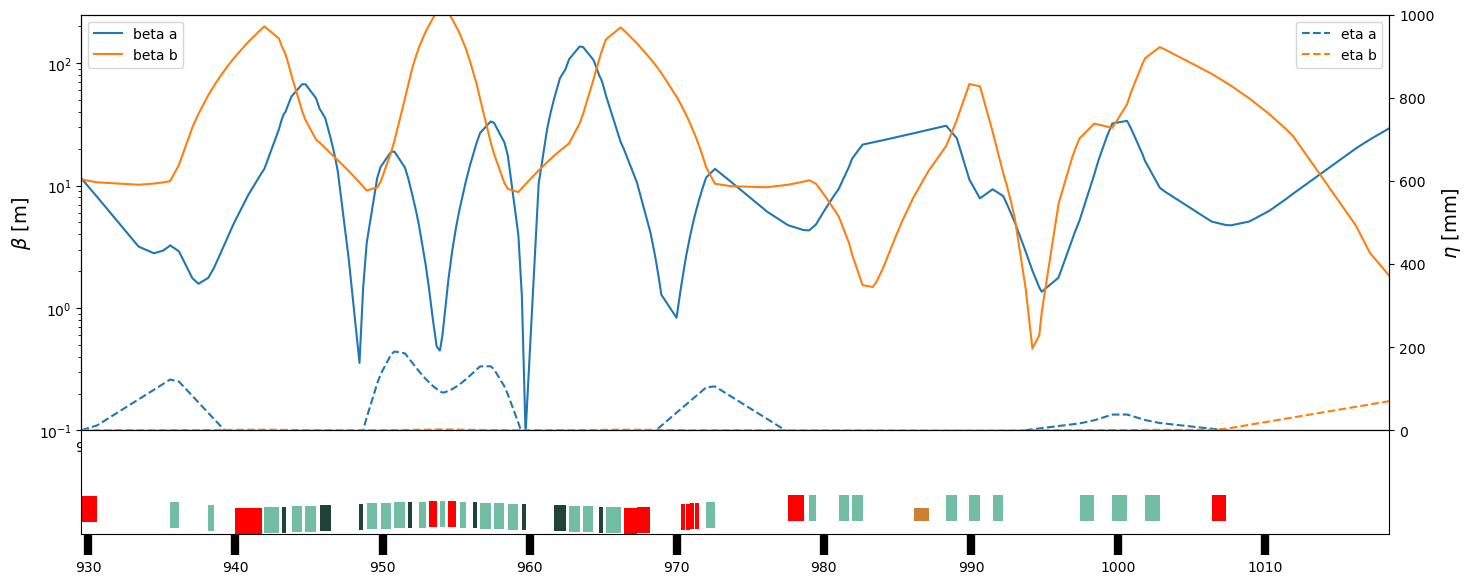

In [48]:
# Plot twiss if you want
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,bunch_beta_x,label='beta a')
ax.semilogy(s,bunch_beta_y,label='beta b')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,bunch_eta_x*1e3,'C0--',label='eta a')
ax_r.plot(s,bunch_eta_y*1e3,'C1--',label='eta b')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=tao.ele_head('BEGBC20')['s']
zmax=tao.ele_head('PDUMP')['s']

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])
ax_r.set_ylim([0,1000])
plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

In [49]:
tao.cmd("show version")

['Date: 2024/04/10 09:22:29']

In [50]:
tao.ele_gen_attribs('L0BF');

In [51]:
# Plot the beam at the start of the sim
# P = ParticleGroup(data=tao.bunch_data('L0AFEND'))
# # Select out live particles
# P = P[P.status==1]
# P.drift_to_z()
# # General lPS plot and transverse profile
# P.plot('delta_t', 'energy',bins=300)
# P.plot('y', 'energy')

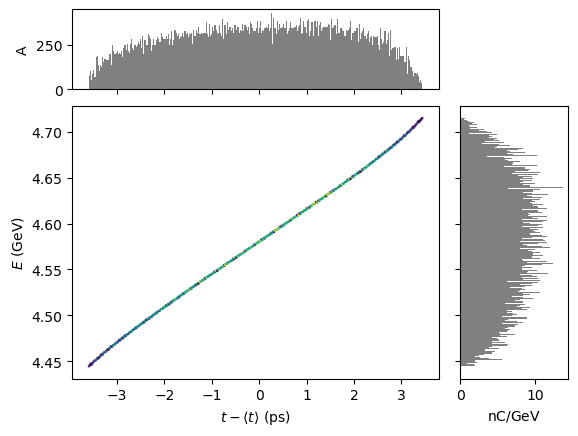

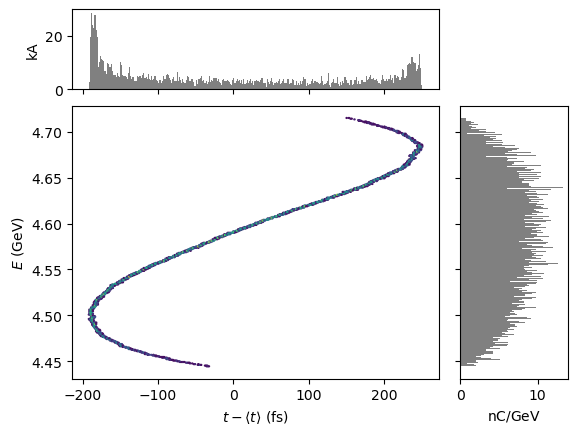

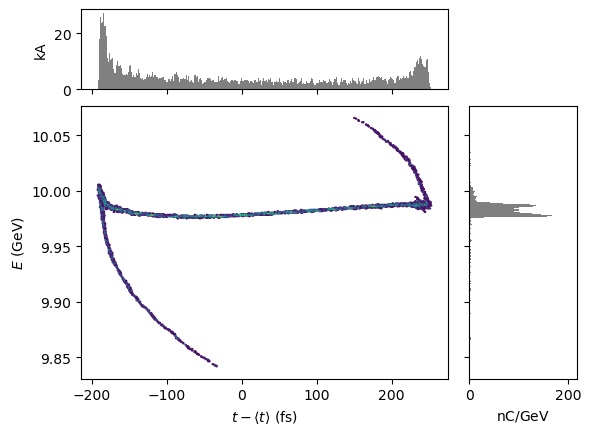

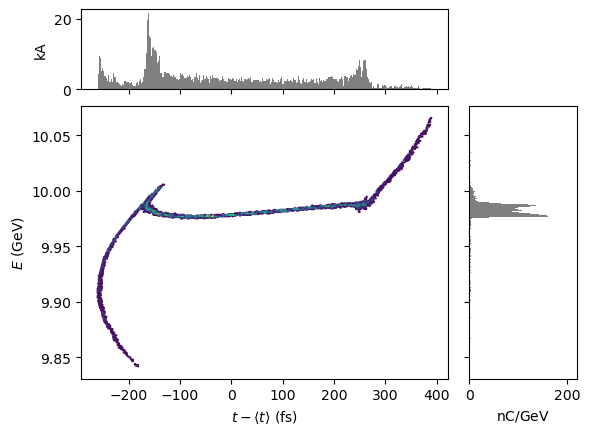

In [52]:
# P = ParticleGroup(data=tao.bunch_data('L0BFEND'))
# # Select out live particles
# P = P[P.status==1]
# P.drift_to_z()
# # General lPS plot and transverse profile
# P.plot('delta_t', 'energy',bins=300)
# # P.plot('x', 'y')

# P = ParticleGroup(data=tao.bunch_data('BC11CBEG'))
# # Select out live particles
# P = P[P.status==1]
# P.drift_to_z()
# # General lPS plot and transverse profile
# P.plot('delta_t', 'energy',bins=300)
# # P.plot('x', 'y')

# P = ParticleGroup(data=tao.bunch_data('BC11CEND'))
# # Select out live particles
# P = P[P.status==1]
# P.drift_to_z()
# # General lPS plot and transverse profile
# P.plot('delta_t', 'energy',bins=300)
# # P.plot('x', 'y')

P = ParticleGroup(data=tao.bunch_data('BEGBC14_1'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# General lPS plot and transverse profile
P.plot('delta_t', 'energy',bins=300)

P = ParticleGroup(data=tao.bunch_data('ENDBC14_2'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# General lPS plot and transverse profile
P.plot('delta_t', 'energy',bins=300)

P = ParticleGroup(data=tao.bunch_data('BEGBC20'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# General lPS plot and transverse profile
P.plot('delta_t', 'energy',bins=300)

P = ParticleGroup(data=tao.bunch_data('PENT'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# General lPS plot and transverse profile
P.plot('delta_t', 'energy',bins=300)

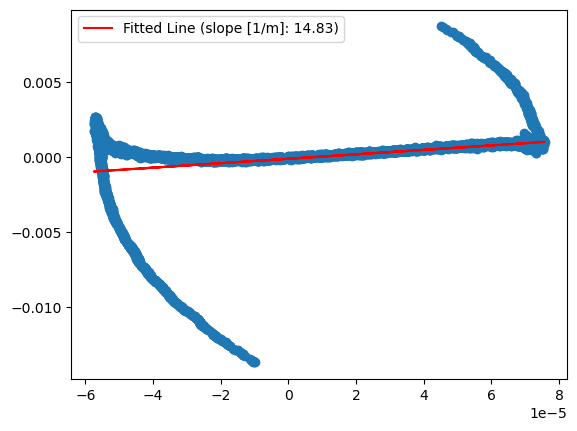

In [53]:
from scipy.stats import linregress
# Grab the beam at BC20
P = ParticleGroup(data=tao.bunch_data('BEGBC20'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# Fit a straight line to calculate the chirp at BC20BEG
xv = (P.t-np.mean(P.t))*3e8;# zeta value in m
yv = P.gamma/np.mean(P.gamma)-1;# delta value

# Select bounds on x-values to fit the chirp in the core of the beam
x_min = -2e-13*3e8  # Lower bound
x_max = 2e-13*3e8  # Upper bound

# Find indices within the selected bounds
indices = np.where((xv >= x_min) & (xv <= x_max))

# Subset x and y arrays based on selected bounds
x_subset = xv[indices]
y_subset = yv[indices]


# Fit a straight line to the data
slope, intercept, _, _, _ = linregress(x_subset, y_subset)
# Plot the particle coordinates

plt.scatter(xv,yv)

# Plot the fitted line

plt.plot(xv, slope * xv + intercept, color='red', label=f'Fitted Line (slope [1/m]: {slope:.2f})')
plt.legend()
plt.show()

In [54]:
# Look at the R56 of BC20 and see if the slippage of the particles makes sense (it doesn't)
R56 = 7e-3;# BC20R56
deltaz = R56*slope*1e-4
print(deltaz)

1.0380761025404643e-05


In [55]:
P = ParticleGroup(data=tao.bunch_data('BEGBC20'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
P.write('BeamAtBEGBC20.h5');

## Track the beam from BEGBC20 to the Dump re-matching by hand at BEGBC20

In [56]:
# P = ParticleGroup('BeamAtBEGBC20.h5');# The beam in the facet2-lattice git repo
# #P = ParticleGroup('L0AFEND_matched.h5')# Matched beam
# P.data.update(resample_particles(P, n=10000))
# P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('BEGBC20','ele.e_tot')[0]*1e-6/0.511;
# P.x=P.x-np.mean(P.x);# Center the beam by hand
# P.y=P.y-np.mean(P.y);# Center the beam by hand
# P.twiss_match(plane='x',beta=tao.lat_list('BEGBC20','ele.a.beta'),alpha=tao.lat_list('BEGBC20','ele.a.alpha'),inplace=True)
# P.twiss_match(plane='y',beta=tao.lat_list('BEGBC20','ele.b.beta'),alpha=tao.lat_list('BEGBC20','ele.b.alpha'),inplace=True)
# P.write('BeamAtBEGBC20_matched.h5');

In [57]:
# # Change the staring input beam and track_start
# tao.cmd('set beam_init position_file=BeamAtBEGBC20_matched.h5')# IF you want to change the beam to the new matched beam at the start
# tao.cmd('set beam_init track_start=BEGBC20')# 
# tao.cmd('reinit beam')
# print('Track start: ', tao.beam()['track_start'])
# tao.beam_init()['position_file']

In [58]:
# # Track the particles
# tao.cmd('call /Users/cemma/Documents/Work/FACET-II/Bmad_sims/Activate_CSR.tao');
# tao.cmd('csroff') #only works once we define the alias "csroff" in the next section.
# tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
# tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

In [59]:
# # Check that the beam Twiss at BEGBC20 correspond to the design twiss 
# P = ParticleGroup(data=tao.bunch_data('BEGBC20'))
# #P = ParticleGroup('BeamAtBEGBC20_matched.h5');
# print(P.twiss('x'))
# print(tao.lat_list('BEGBC20','ele.a.alpha'))
# print(tao.lat_list('BEGBC20','ele.a.beta'))
# print(tao.lat_list('BEGBC20','ele.a.eta'))
# print(P.twiss('y'))
# print(tao.lat_list('BEGBC20','ele.b.alpha'))
# print(tao.lat_list('BEGBC20','ele.b.beta'))
# print(tao.lat_list('BEGBC20','ele.b.eta'))

In [60]:
np.mean(P.py)

2388.746266880859

In [61]:
# P = ParticleGroup(data=tao.bunch_data('BEGBC20'))
# # Select out live particles
# P = P[P.status==1]
# P.drift_to_z()
# # General lPS plot and transverse profile
# P.plot('delta_t', 'energy',bins=300)

# P = ParticleGroup(data=tao.bunch_data('PENT'))
# # Select out live particles
# P = P[P.status==1]
# P.drift_to_z()
# # General lPS plot and transverse profile
# P.plot('delta_t', 'energy',bins=300)

In [62]:
# bunch_beta_x=np.array([tao.bunch_params(x)['twiss_beta_x'] for x in floorplan.Index])
# bunch_beta_y=np.array([tao.bunch_params(x)['twiss_beta_y'] for x in floorplan.Index])
# bunch_etot=np.array([tao.bunch_params(x)['centroid_p0c']*0.511 for x in floorplan.Index])
# bunch_eta_x=np.array([tao.bunch_params(x)['twiss_eta_x'] for x in floorplan.Index])
# bunch_eta_y=np.array([tao.bunch_params(x)['twiss_eta_y'] for x in floorplan.Index])
# # Plot twiss if you want
# fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
# fig.clf()
# ax,ax_fp=format_longitudinal_plot(fig)

# ax.semilogy(s,bunch_beta_x,label='beta a')
# ax.semilogy(s,bunch_beta_y,label='beta b')
# plt.legend(loc=2)
# ax.set_ylim([0.1,250])
# ax_r=ax.twinx()
# ax_r.plot(s,bunch_eta_x*1e3,'C0--',label='eta a')
# ax_r.plot(s,bunch_eta_y*1e3,'C1--',label='eta b')
# plt.legend(loc=1)
# #ax_r.plot(s,beta_y,'k--')
# #ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

# ax.set_facecolor('w')
# zmin=tao.ele_head('BEGBC20')['s']
# zmax=tao.ele_head('PDUMP')['s']

# ax.set_xlabel('Z [m]',fontsize=14)
# ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
# ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

# ax.set_xlim([zmin,zmax])
# ax_fp.set_ylim([-1,3])

# plt.show()

In [63]:
tao.cmd('place floor beambeta')



[]

# Track Beam to BC11END


In [64]:
#elements = tao.lat_ele_list()
#print(elements)
#using BC11CEND


In [65]:
#tao.cmd("show plot -templates")


In [66]:
#tao.cmd("set plot lattice component = BC11CEND")


In [67]:
tao.cmd('set beam_init track_end = "BC11CEND"')
tao.cmd('reinit beam')
#tao.cmd('track')



[]

In [68]:
data = tao.bunch_data('end')
data.keys()





dict_keys(['x', 'px', 'y', 'py', 't', 'pz', 'status', 'weight', 'z', 'species'])

In [69]:
from pmd_beamphysics import ParticleGroup

P = ParticleGroup(data=data)
P

<ParticleGroup with 10000 particles at 0x7f908c7e7170>

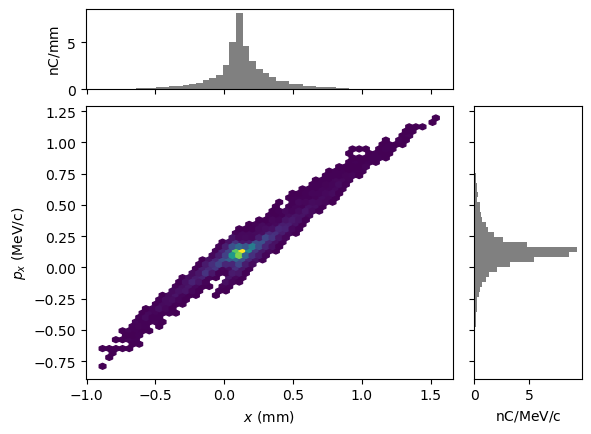

In [70]:
P.plot('x', 'px')

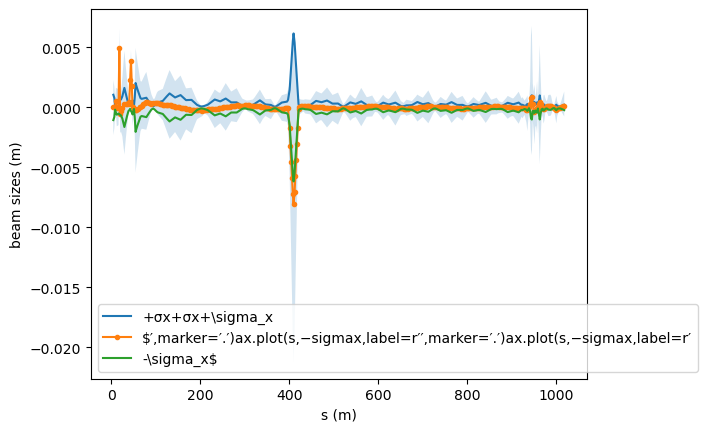

In [71]:
s = tao.bunch_comb('s')
mean_x = tao.bunch_comb('x')
max_x = mean_x + tao.bunch_comb('rel_max.1')
min_x = mean_x + tao.bunch_comb('rel_min.1')
sigma_x = np.sqrt(tao.bunch_comb('sigma.11'))
fig, ax = plt.subplots()

ax.fill_between(s, min_x, max_x, alpha=0.2)
ax.plot(s, sigma_x, label=r'+σx+σx+\sigma_x')
ax.plot(s, mean_x, label=r'$′,marker=′.′)ax.plot(s,−sigmax,label=r′′,marker=′.′)ax.plot(s,−sigmax,label=r′', marker='.')
ax.plot(s, -sigma_x, label=r'-\sigma_x$')
ax.set_xlabel('s (m)')
ax.set_ylabel('beam sizes (m)')
plt.legend()


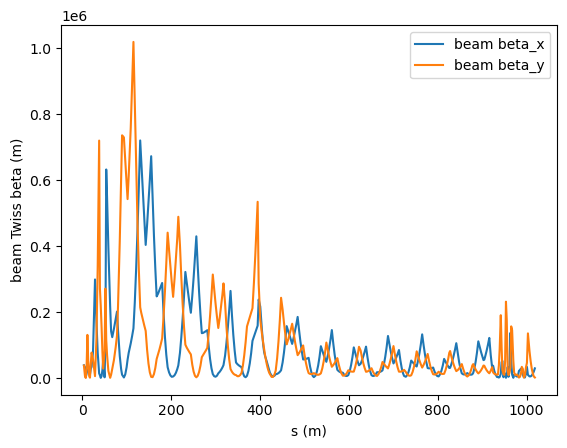

In [72]:
plt.plot(tao.bunch_comb('s'), 1000*tao.bunch_comb('x.beta'), label='beam beta_x')
plt.plot(tao.bunch_comb('s'), 1000*tao.bunch_comb('y.beta'), label='beam beta_y')
plt.xlabel('s (m)')
plt.ylabel('beam Twiss beta (m)')
plt.legend()

In [73]:
stats = tao.bunch_params('end')
stats

{'twiss_beta_x': 37.7075597778126,
 'twiss_alpha_x': -2.63759717532576,
 'twiss_gamma_x': 0.211016541674179,
 'twiss_phi_x': 0.0,
 'twiss_eta_x': -0.0499522910446006,
 'twiss_etap_x': -0.00386092544081068,
 'twiss_sigma_x': 0.000225002783645743,
 'twiss_sigma_p_x': 1.68318529199508e-05,
 'twiss_emit_x': 1.34260219824996e-09,
 'twiss_norm_emit_x': 2.62171534591992e-05,
 'twiss_beta_y': 3.31726961184019,
 'twiss_alpha_y': -0.898567104108916,
 'twiss_gamma_y': 0.544852560110136,
 'twiss_phi_y': 0.0,
 'twiss_eta_y': 0.0802564281780961,
 'twiss_etap_y': 0.00592011630848362,
 'twiss_sigma_y': 9.04449780808431e-05,
 'twiss_sigma_p_y': 3.66550292678964e-05,
 'twiss_emit_y': 2.465972024356e-09,
 'twiss_norm_emit_y': 4.8153330206746e-05,
 'twiss_beta_z': 0.0253712327285992,
 'twiss_alpha_z': 0.61798423605701,
 'twiss_gamma_z': 54.467377710711,
 'twiss_phi_z': 0.0,
 'twiss_eta_z': 0.0,
 'twiss_etap_z': 0.0,
 'twiss_sigma_z': 5.14582972075691e-05,
 'twiss_sigma_p_z': 0.00238425586682134,
 'twiss_e

In [74]:
# Example command to get general attributes of the beam at the endpoint
info_at_bc11cend = tao.ele_gen_attribs('BC11CEND')
print(info_at_bc11cend)

# To get more detailed data or results, you might use:
bunch_params = tao.bunch_params('BC11CEND')
print(bunch_params)


{'L': 0.0, 'units#L': 'm', 'TILT': 0.0, 'units#TILT': 'rad', 'X_GAIN_ERR': 0.0, 'units#X_GAIN_ERR': 'm', 'Y_GAIN_ERR': 0.0, 'units#Y_GAIN_ERR': 'm', 'CRUNCH': 0.0, 'units#CRUNCH': 'rad', 'NOISE': 0.0, 'units#NOISE': '', 'OSC_AMPLITUDE': 0.0, 'units#OSC_AMPLITUDE': 'm', 'X_GAIN_CALIB': 0.0, 'units#X_GAIN_CALIB': 'm', 'Y_GAIN_CALIB': 0.0, 'units#Y_GAIN_CALIB': 'm', 'CRUNCH_CALIB': 0.0, 'units#CRUNCH_CALIB': 'rad', 'X_OFFSET_CALIB': 0.0, 'units#X_OFFSET_CALIB': 'm', 'Y_OFFSET_CALIB': 0.0, 'units#Y_OFFSET_CALIB': 'm', 'TILT_CALIB': 0.0, 'units#TILT_CALIB': 'rad', 'DE_ETA_MEAS': 0.0, 'units#DE_ETA_MEAS': '', 'N_SAMPLE': 0.0, 'units#N_SAMPLE': '', 'X_DISPERSION_ERR': 0.0, 'units#X_DISPERSION_ERR': 'm', 'Y_DISPERSION_ERR': 0.0, 'units#Y_DISPERSION_ERR': 'm', 'X_DISPERSION_CALIB': 0.0, 'units#X_DISPERSION_CALIB': 'm', 'Y_DISPERSION_CALIB': 0.0, 'units#Y_DISPERSION_CALIB': 'm', 'X_PITCH': 0.0, 'units#X_PITCH': 'rad', 'Y_PITCH': 0.0, 'units#Y_PITCH': 'rad', 'X_OFFSET': 0.0, 'units#X_OFFSET': 'm'

In [75]:
tao.cmd('show track')

['#   Ix          S        X (*1E3)      Y (*1E3)      Z (*1E3)              px            py            pz',
 '    1     0.000000        0.000000      0.000000      0.000000      0.00000000    0.00000000    0.00000000',
 '    2     1.703019        0.000000      0.000000     -0.000000      0.00000000    0.00000000    0.00000000',
 '    3     3.406038        0.000000      0.000000      0.000000      0.00000000    0.00000000    0.00000000',
 '    4     5.109057        0.000000      0.000000      0.000000      0.00000000    0.00000000    0.00000000',
 '    5     6.812075        0.000000      0.000000      0.000000      0.00000000    0.00000000    0.00000000',
 '    6     8.515094        0.000000      0.000000      0.000000      0.00000000    0.00000000    0.00000000',
 '    7    10.218113        0.000000      0.000000      0.000000      0.00000000    0.00000000    0.00000000',
 '    8    11.921132       -0.000000      0.000000     -0.000000     -0.00000000    0.00000000    0.00000000',
 '

## Again, with CSR

In [76]:
 tao.cmd('csron')

[]

In [77]:
tao.cmd('set global track_type = beam')
#tao.cmd('set global track_type = single')

[]

In [78]:
 P = ParticleGroup(data=tao.bunch_data('MIP'))
 # Select out live particles
 P = P[P.status==1]
 P.drift_to_z()

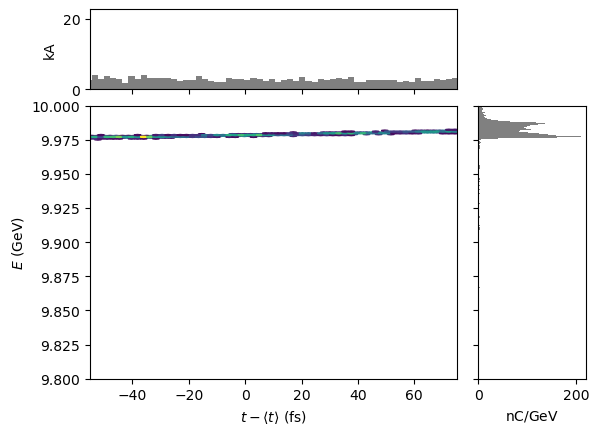

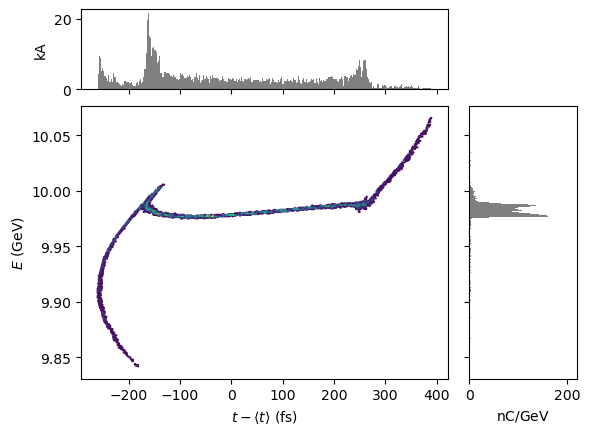

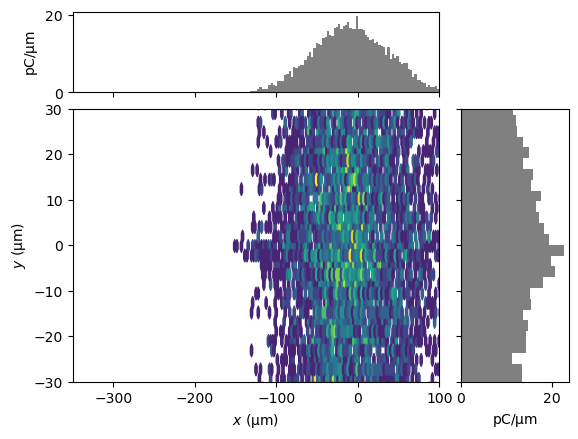

In [79]:
P.plot('delta_t', 'energy',bins=300,xlim=[-55e-15,75e-15],ylim=[9.8e9,10.0e9])
P.plot('delta_t', 'energy',bins=300)
P.plot('x', 'y',bins=100,xlim=[-350e-6,100e-6],ylim=[-30e-6,30e-6])

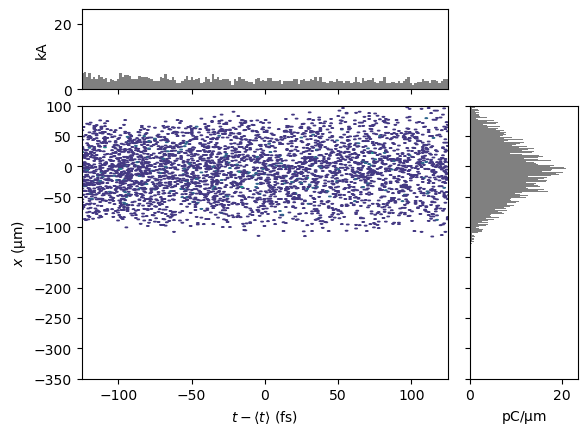

In [80]:
P.plot('delta_t', 'x',bins=400,xlim=[-125e-15,125e-15],ylim=[-350e-6,100e-6])

# Add the laser heater modulation to the beam

In [81]:
import numpy as np
from scipy.special import jn as besselj

def addLHmodulation(inputBeam, Elaser, showplots=False):
    # Hardcode FACET-II laser and undulator parameters
    # Laser parameters
    lambda_laser = 760e-9
    sigmar_laser = 200e-6
    sigmat_laser = (6 / 2.355) * 1e-12
    Plaser = Elaser / np.sqrt(2 * np.pi * sigmat_laser**2)
    offset = 0.0  # laser to e-beam offset if you want you can add it

    # Undulator parameters
    K = 1.1699
    lambdaw = 0.054
    Nwig = 9
    
    # Electron beam
    outputBeam = inputBeam.copy()
    x = inputBeam.x - np.mean(inputBeam.x)
    y = inputBeam.y - np.mean(inputBeam.y)
    gamma = inputBeam.gamma
    gamma0 = np.mean(inputBeam.gamma) 
    t = inputBeam.t-np.mean(inputBeam.t);
    
    # Calculated parameters
    lambda_r = lambdaw / 2 / gamma0**2 * (1 + K**2 / 2)  # Assumes planar undulator
    omega = 2 * np.pi * 299792458 / lambda_r  # Resonant frequency
    JJ = besselj(0, K**2 / (4 + 2 * K**2)) - besselj(1, K**2 / (4 + 2 * K**2))
    totalLaserEnergy = np.sqrt(2 * np.pi * sigmat_laser**2) * Plaser
    
    # Laser is assumed Gaussian with peak power Plaser
    # This formula from eq. 8 Huang PRSTAB 074401 2004
    mod_amplitude = np.sqrt(Plaser / 8.7e9) * K * lambdaw * Nwig / gamma0 / sigmar_laser * JJ
    print(mod_amplitude / np.sqrt(Plaser))
    # offset = 1.0  # temporal offset between laser and e-beam in units of laser wavelengths
    
    # Calculate induced modulation deltagamma
    deltagamma = mod_amplitude * np.exp(-0.25 * (x**2 + y**2) / sigmar_laser**2) * \
                 np.sin(omega * t + offset * 2 * np.pi) * \
                 np.exp(-0.5 * ((t - offset * sigmat_laser) / sigmat_laser)**2)

    outputBeam.gamma = inputBeam.gamma + deltagamma

    return outputBeam, deltagamma, t

In [82]:
# beamatLHWithoutModulation = ParticleGroup(data=tao.bunch_data('HTRUNDF'))# Grab the beam at the heater location
# beamatLHWithLHModulation, deltagamma, t = addLHmodulation(beamatLHWithoutModulation, 1e-3)
# # Plot lps before/after modulation
# beamatLHWithoutModulation.plot('delta_t','energy',bins=200)
# #beamatLHWithoutModulation.plot('x','y',bins=200)
# beamatLHWithLHModulation.plot('delta_t','energy',bins=200)

In [83]:
tao.cmd('show beam');